# 📘 Ensemble 모델 SHAP 분석 보고서 (Model-level)

본 노트북은 자전거 대여 수요 예측 프로젝트에서 사용된
LightGBM, XGBoost, RandomForest 기반 앙상블 모델에 대해
**SHAP(SHapley Additive exPlanations)** 을 활용한 해석을 수행한다.

본 분석의 목적은 다음과 같다.

1. 각 베이스 모델이 어떤 피처를 근거로 수요를 예측했는지 설명한다.
2. 모델별 SHAP 결과를 비교하여 공통 중요 요인과 차별 요인을 도출한다.
3. 이를 통해 앙상블 모델의 예측 논리를 해석 가능하게 제시한다.


## 앙상블 SHAP 해석 방식 선택

앙상블 모델에 대한 SHAP 해석은 다음 3가지 방식이 가능하다.

### 1️⃣ 베이스 모델별 SHAP 분석 (본 보고서에서 채택)
- 각 모델(LGBM, XGB, RF)에 대해 개별적으로 SHAP 계산
- 모델별 중요 피처 및 영향 방향 비교
- 앙상블이 공통적으로 의존하는 요인 도출

이 방식은 TreeExplainer를 그대로 활용할 수 있어
가장 정확하고 안정적인 해석이 가능하다.

### 2️⃣ 가중 SHAP 근사
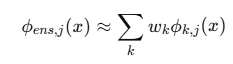

앙상블 예측이 가중 평균일 경우,
모델별 SHAP 값을 가중합하여 앙상블 SHAP처럼 요약할 수 있다.
단, 이는 근사(approximation)이므로 보조 분석으로만 사용한다.

### 3️⃣ 앙상블을 하나의 모델처럼 직접 SHAP
KernelExplainer를 사용해 앙상블을 하나의 함수로 설명할 수 있으나,
계산 비용과 분산이 커 실무적으로 비권장한다.

📌 본 보고서에서는 **1번 방식(모델별 SHAP 분석)** 을 사용한다.

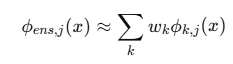

### 환경준비

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

shap.initjs()


## 프로젝트 루트 경로 설정

노트북 위치와 관계없이 `models/` 와 `Data/` 폴더를 기준으로
프로젝트 루트를 자동 탐색한다.


In [2]:
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(10):
        if (cur / "models").exists() and (cur / "Data").exists():
            return cur
        cur = cur.parent
    raise RuntimeError("Project root not found")

PROJECT_ROOT = find_project_root(Path.cwd())
PROJECT_ROOT


PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting')

## 분석 대상 설정


In [3]:
CITY = "wdc"          # "seoul" | "wdc"
VARIANT = "IQR"         # "IQR" | "no_IQR"
TARGET_COL = "rental_count"

SAMPLE_N = 5000
RANDOM_STATE = 42


## 데이터 및 모델 경로 정의


In [4]:
def get_data_path(city):
    if city == "seoul":
        return PROJECT_ROOT / "Data/interim/seoul/seoul_rental_data.csv"
    if city == "wdc":
        return PROJECT_ROOT / "Data/interim/washington/dc_rental_data.csv"

def get_model_paths(city, variant):
    base = "Seoul" if city == "seoul" else "WashingtonDC"
    suffix = "" if variant == "IQR" else "_no_iqr"
    vdir = PROJECT_ROOT / "models" / variant

    return {
        "lgbm": vdir / f"{base}_LGBM_all{suffix}.pkl",
        "xgb":  vdir / f"{base}_XGB_all{suffix}.pkl",
        "rf":   vdir / f"{base}_RF_all{suffix}.pkl",
    }


## 데이터 로드 및 입력 행렬 구성

- 타겟 변수는 `rental_count`
- 문자열, 날짜 등 비수치 컬럼은 제거
- 수치형 피처만 사용
- 시간대 피처(`quarter_flag`)는 정수형으로 유지


In [5]:
df = pd.read_csv(get_data_path(CITY))

if "quarter of day" in df.columns:
    df = df.rename(columns={"quarter of day": "quarter_flag"})

y = df[TARGET_COL].astype(float)
X = df.drop(columns=[TARGET_COL], errors="ignore")
X = X.select_dtypes(include="number").fillna(0.0)

if "quarter_flag" in X.columns:
    X["quarter_flag"] = X["quarter_flag"].astype(int)

X.shape, y.shape


((1402340, 59), (1402340,))

## 모델 입력 피처 정렬

Tree 기반 모델은
학습 시점과 예측 시점의 **피처 개수 및 순서가 다르면 오류가 발생**한다.

따라서 각 모델이 기대하는 피처 목록을 기준으로
입력 데이터를 정렬한다.


In [6]:
def load_model(path):
    return joblib.load(path)

def get_expected_features(model):
    if hasattr(model, "booster_"):
        return model.booster_.feature_name()
    if hasattr(model, "get_booster"):
        return model.get_booster().feature_names
    if hasattr(model, "feature_names_in_"):
        return model.feature_names_in_
    return None

def align_features(X, expected):
    X = X.copy()
    for c in expected:
        if c not in X.columns:
            X[c] = 0.0
    return X[expected]


## SHAP 계산 (Model-level)

Tree 기반 모델이므로 `TreeExplainer`를 사용한다.
동일한 샘플에 대해 모델별 SHAP 값을 계산하여 비교한다.


In [7]:
models = {k: load_model(v) for k, v in get_model_paths(CITY, VARIANT).items()}
expected = {k: get_expected_features(m) for k, m in models.items()}

X_sample = X.sample(n=min(SAMPLE_N, len(X)), random_state=RANDOM_STATE)

def compute_shap_safe(model, X, model_name: str, background_size: int = 200):
    """
    SHAP 계산을 모델별로 안전하게 처리.
    - lgbm/rf: TreeExplainer
    - xgb: TreeExplainer 시도 → 실패하면 Explainer(model.predict, background)로 fallback
    """
    # background는 너무 크면 느림 (특히 fallback일 때)
    bg = X.sample(n=min(background_size, len(X)), random_state=0)

    # 1) 먼저 TreeExplainer 시도 (가장 빠르고 일반적)
    try:
        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X)
        if isinstance(sv, list):
            sv = sv[0]
        return np.array(sv)

    except Exception as e:
        print(f"[WARN] TreeExplainer failed for {model_name}: {type(e).__name__}: {e}")

    # 2) fallback: model.predict 기반 Explainer (모델 구조 파싱 안 하고 함수만 씀)
    #    shap.Explainer는 내부적으로 Permutation/Kernel 계열 선택 → 느릴 수 있음
    explainer = shap.Explainer(model.predict, bg)
    explanation = explainer(X)

    # explanation.values shape: (n_samples, n_features)
    return np.array(explanation.values)



## 모델별 SHAP 시각화 및 해석



===== LGBM =====
sv shape: (5000, 42)  | Xk shape: (5000, 42)


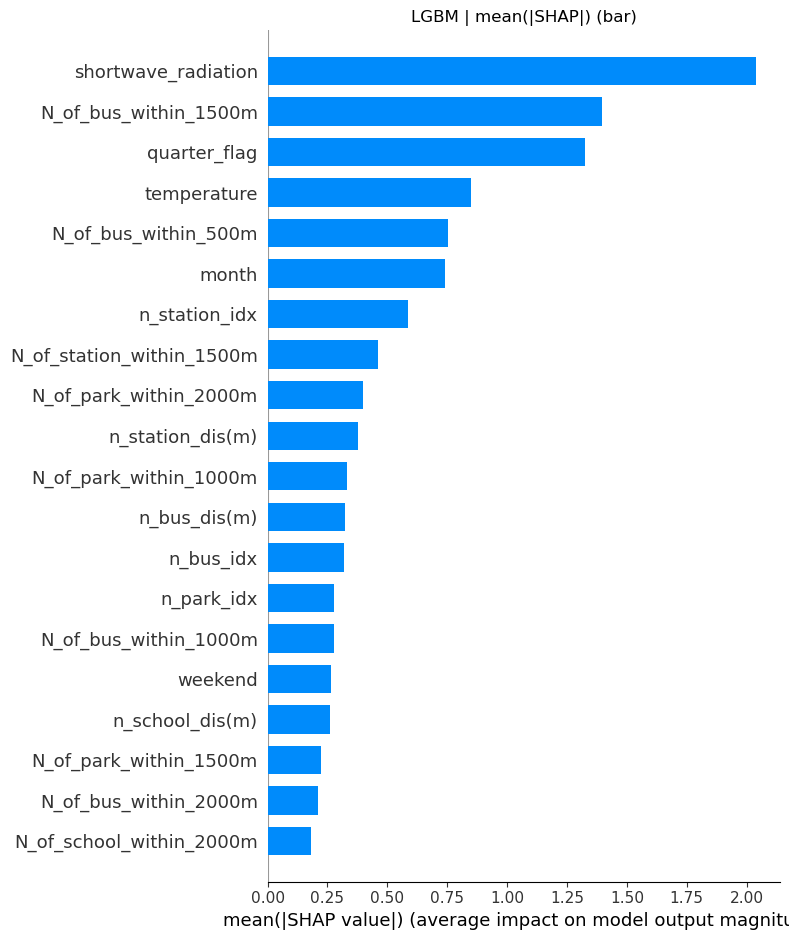

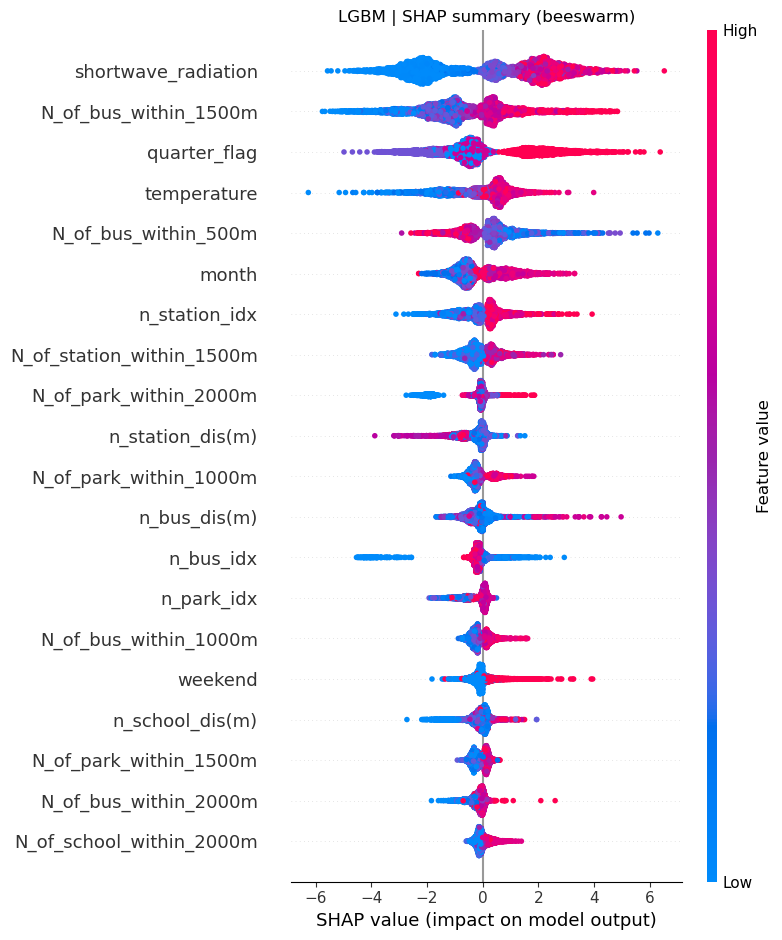

Top5: ['N_of_bus_within_500m', 'temperature', 'quarter_flag', 'N_of_bus_within_1500m', 'shortwave_radiation']


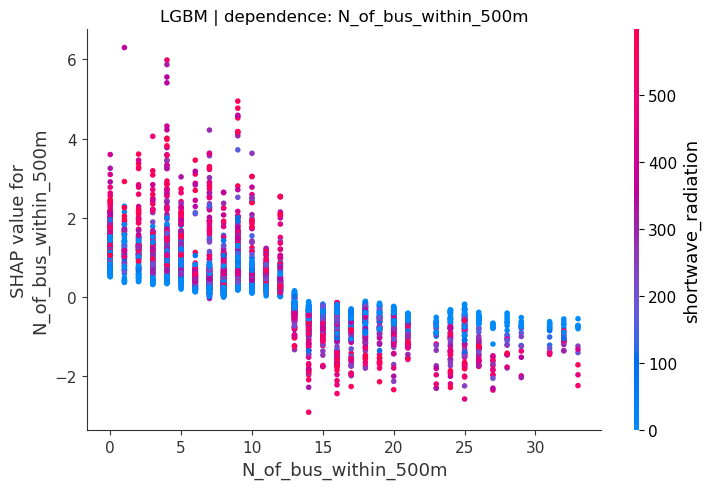

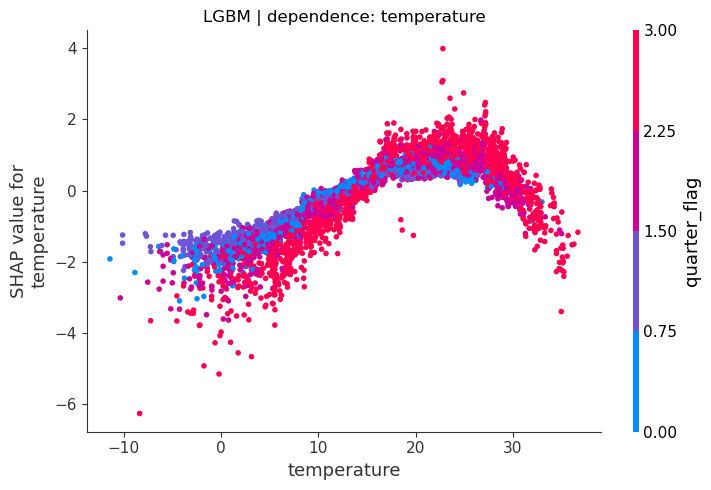

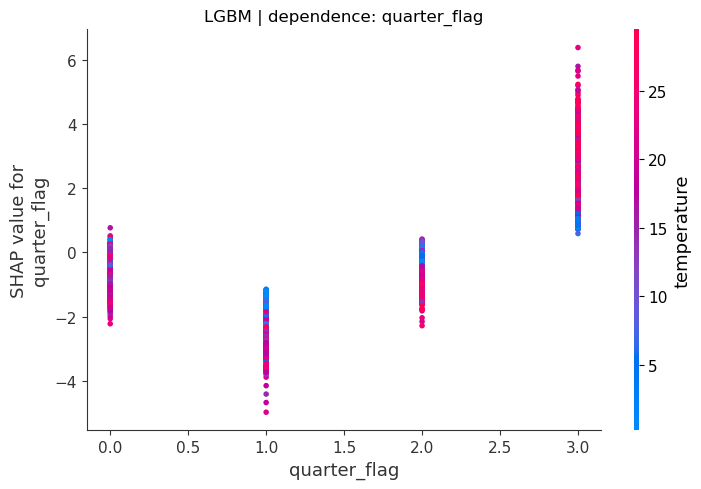

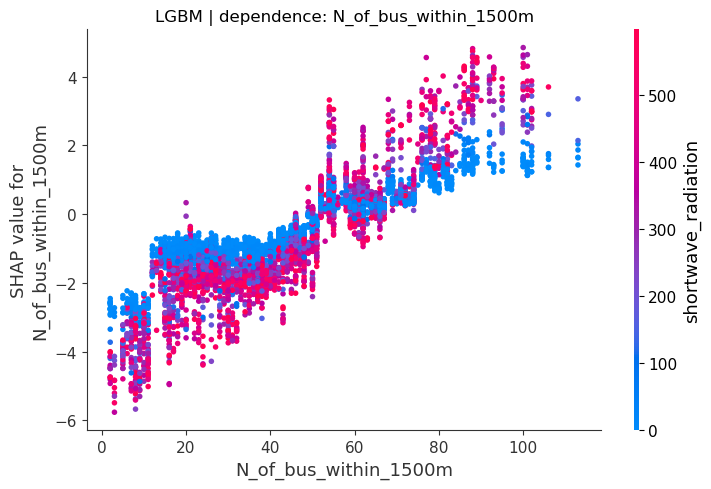

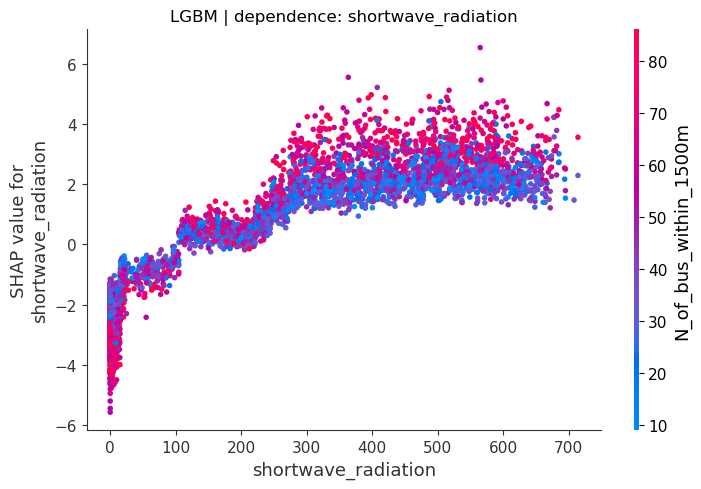

[WARN] TreeExplainer failed for xgb: UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf5 in position 1813: invalid start byte


Permutation explainer: 5001it [05:28, 14.77it/s]                          



===== XGB =====
sv shape: (5000, 42)  | Xk shape: (5000, 42)


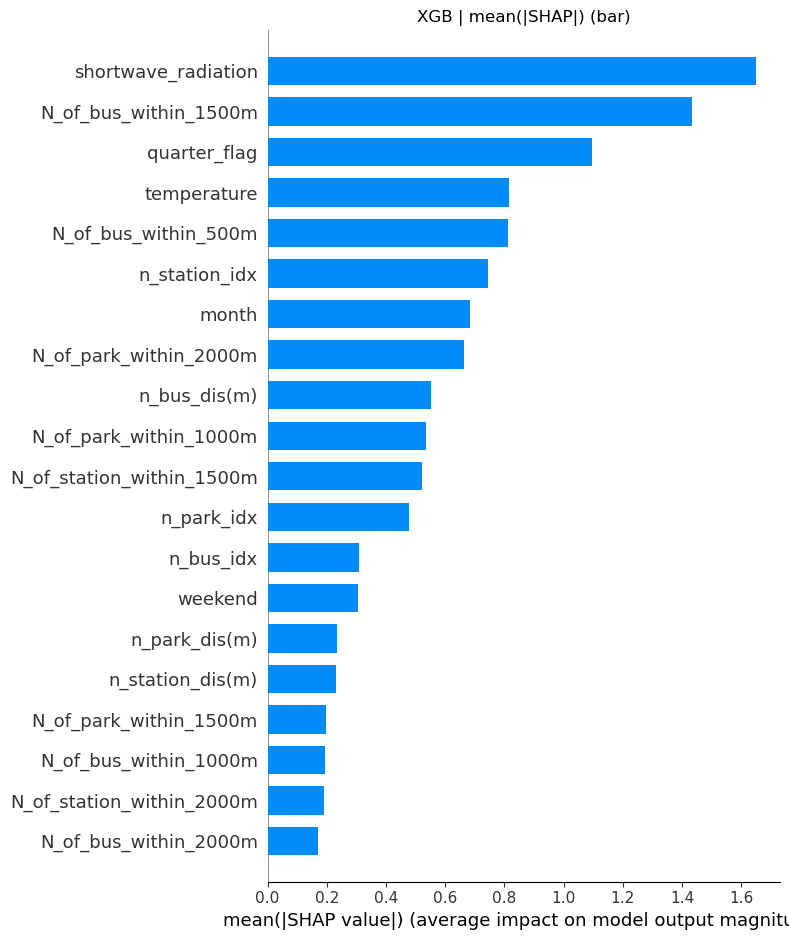

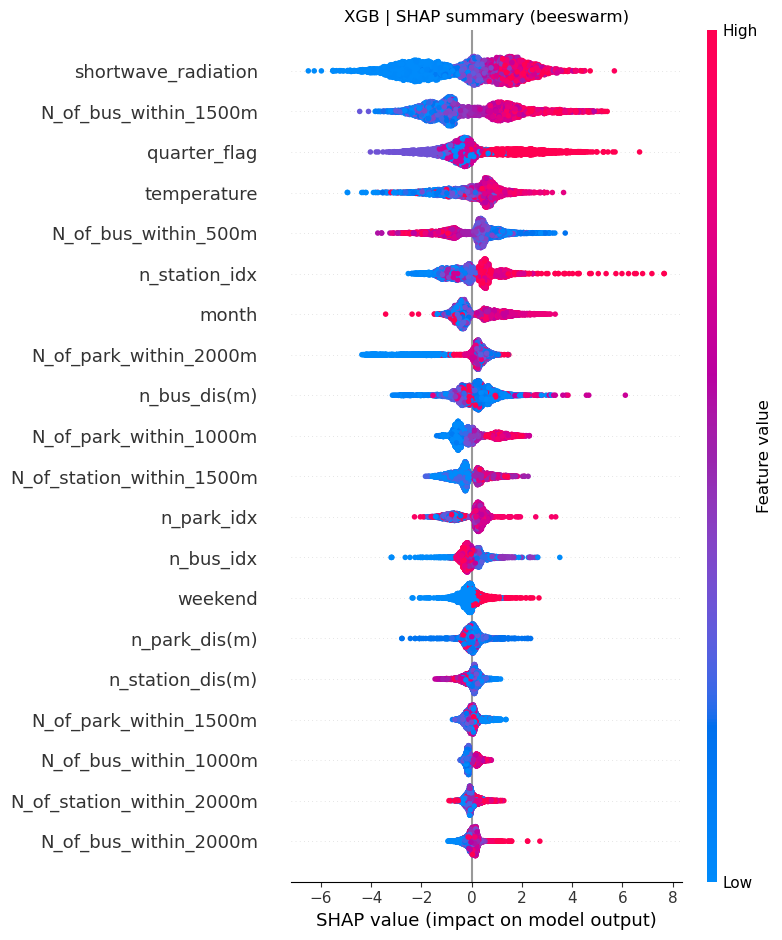

Top5: ['N_of_bus_within_500m', 'temperature', 'quarter_flag', 'N_of_bus_within_1500m', 'shortwave_radiation']


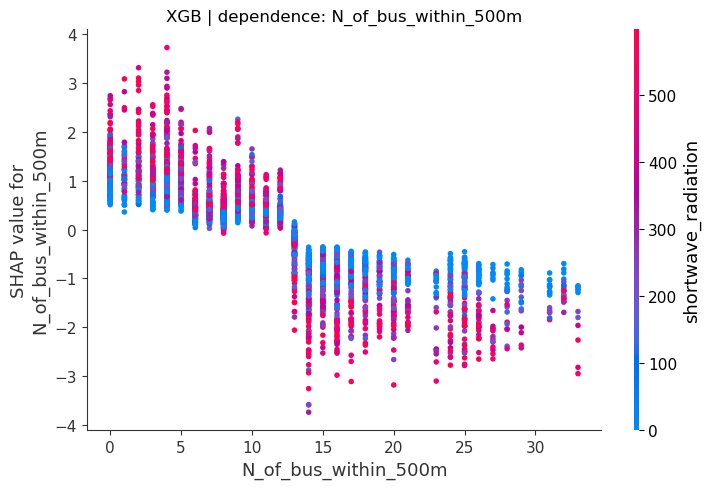

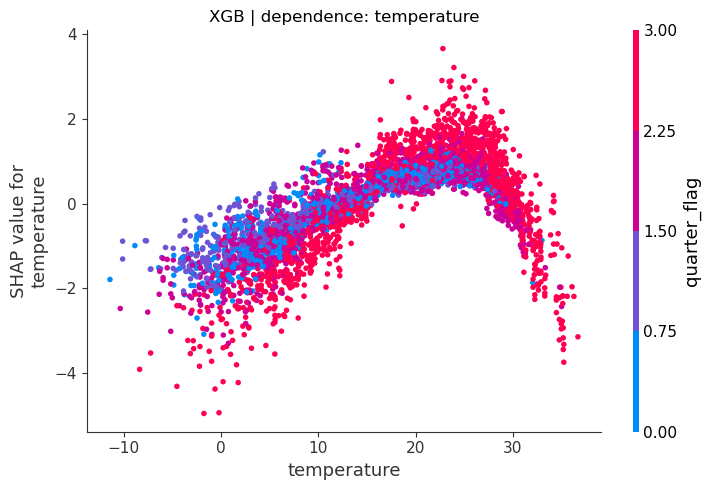

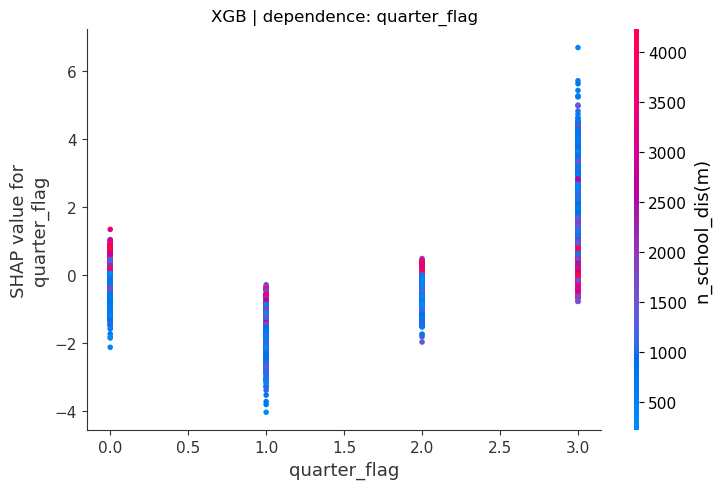

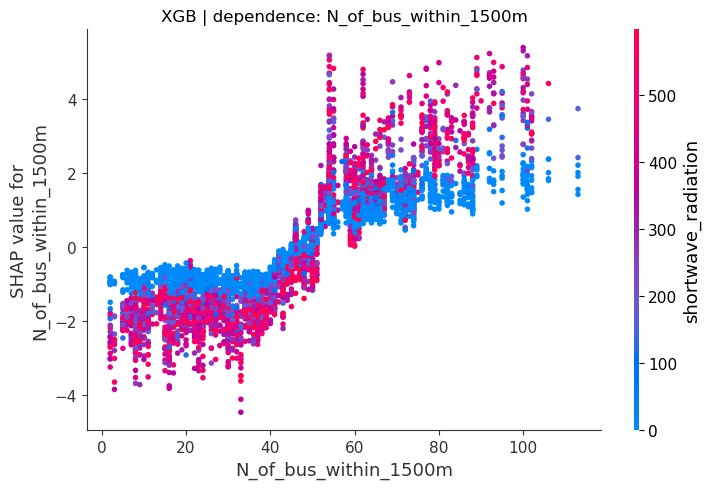

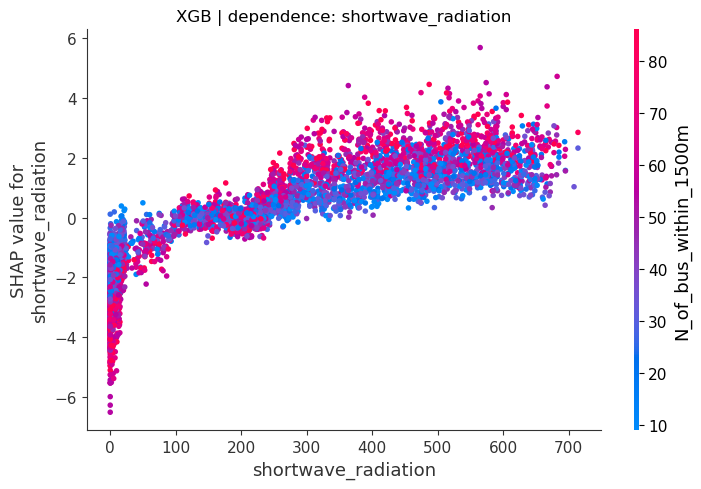


===== RF =====
sv shape: (5000, 42)  | Xk shape: (5000, 42)


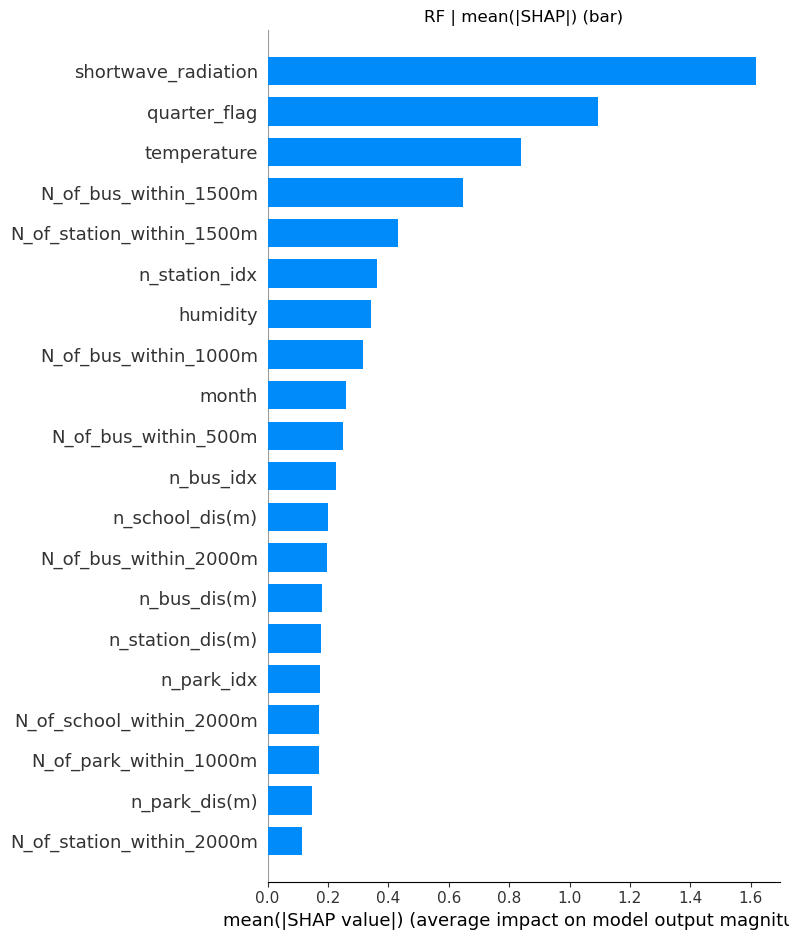

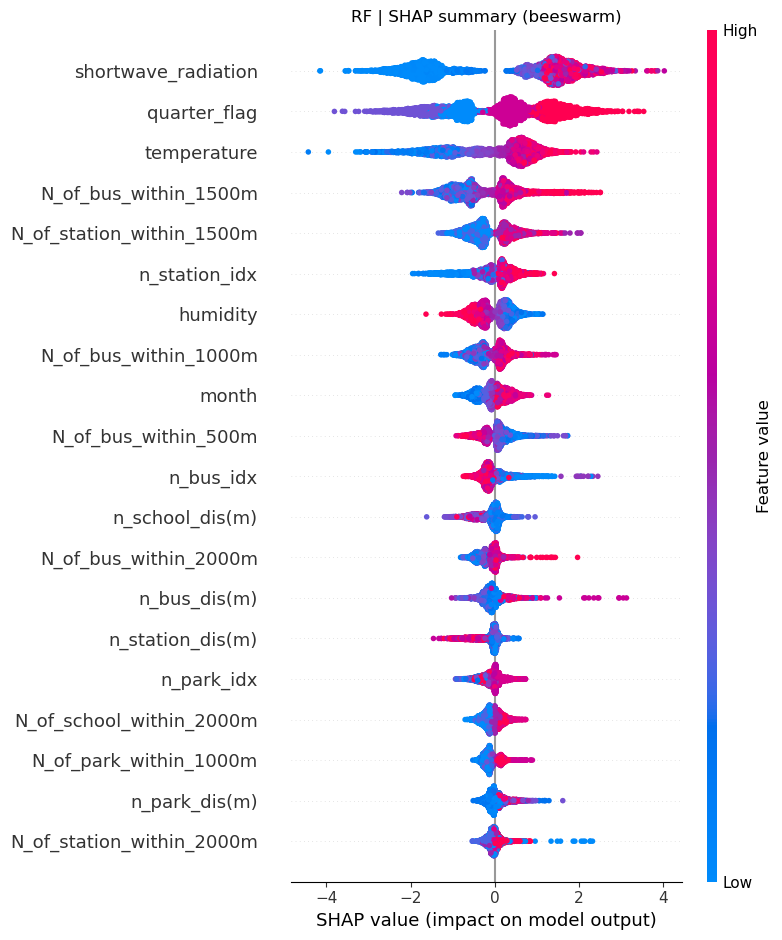

Top5: ['N_of_station_within_1500m', 'N_of_bus_within_1500m', 'temperature', 'quarter_flag', 'shortwave_radiation']


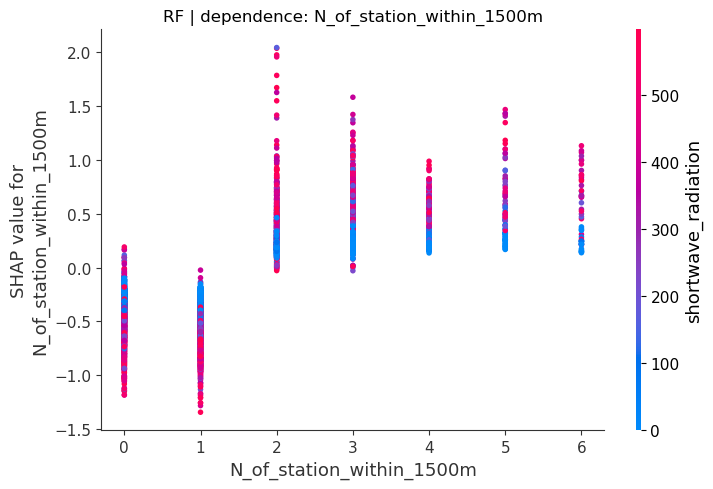

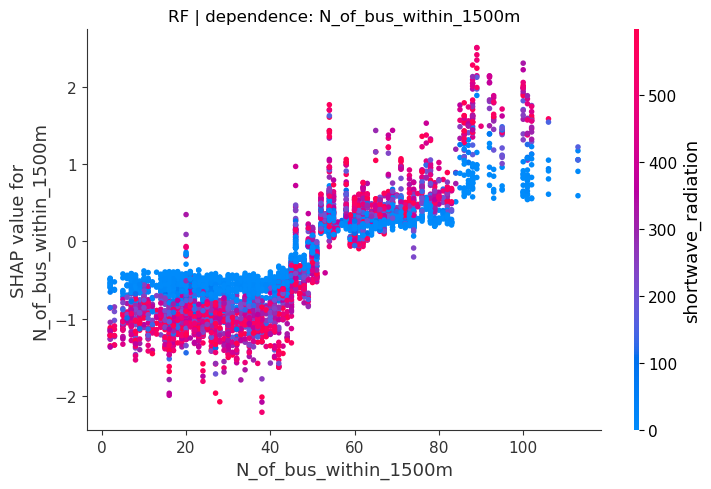

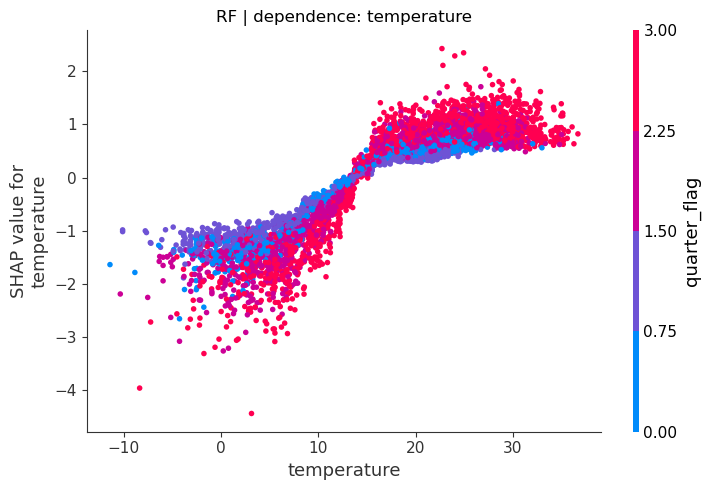

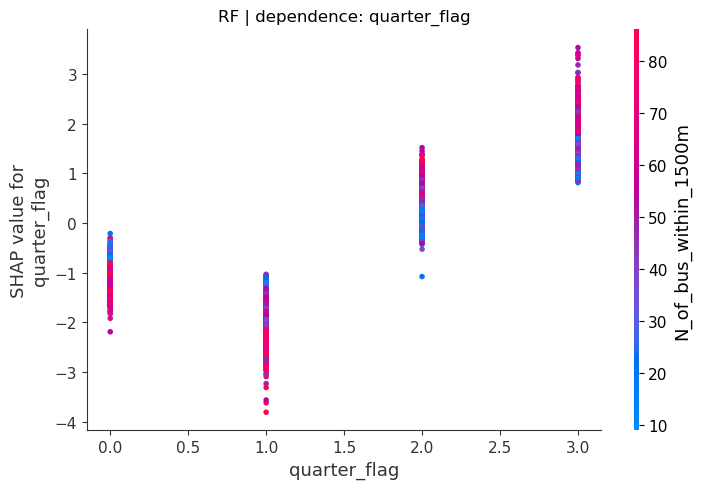

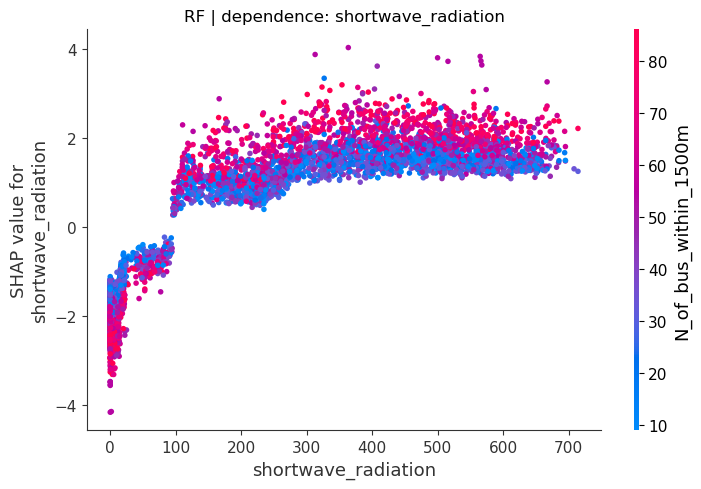

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for name in ["lgbm", "xgb", "rf"]:
    Xk = align_features(X_sample, expected[name])

    sv = compute_shap_safe(models[name], Xk, model_name=name, background_size=200)
    sv = np.asarray(sv, dtype=float)

    # sv shape 안전장치 (혹시 3D로 나오면 2D로)
    if sv.ndim == 3:
        sv = sv[:, :, 0]

    print(f"\n===== {name.upper()} =====")
    print("sv shape:", sv.shape, " | Xk shape:", Xk.shape)

    # --- bar summary ---
    shap.summary_plot(sv, Xk, plot_type="bar", show=False)
    plt.title(f"{name.upper()} | mean(|SHAP|) (bar)")
    plt.tight_layout()
    plt.show()

    # --- beeswarm summary ---
    shap.summary_plot(sv, Xk, show=False)
    plt.title(f"{name.upper()} | SHAP summary (beeswarm)")
    plt.tight_layout()
    plt.show()

    # --- top5 dependence ---
    mean_abs = np.abs(sv).mean(axis=0)
    top5_idx = np.argsort(mean_abs)[-5:]
    top5_features = list(Xk.columns[top5_idx])

    print("Top5:", top5_features)

    for f in top5_features:
        shap.dependence_plot(f, sv, Xk, show=False)
        plt.title(f"{name.upper()} | dependence: {f}")
        plt.tight_layout()
        plt.show()
